### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
from mlxtend.frequent_patterns import apriori, association_rules
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, DayLocator

### Read the Dataset 

In [2]:
df_ = pd.read_csv("file_out2.csv")
df = df_.copy()
df.head()
#df.shape

,Unnamed: 0,InvoiceID,Date,ProductID,TotalSales,Discount,CustomerID,Quantity
0,0,328,2019-12-27,1684,796.610169,143.389831,185,4
1,1,329,2019-12-27,524,355.932203,64.067797,185,2
2,2,330,2019-12-27,192,901.694915,162.305085,230,4
3,3,330,2019-12-27,218,182.754237,32.895763,230,1
4,4,330,2019-12-27,247,780.101695,140.418305,230,4


### Feature Engineering

In [3]:
df.drop(["Unnamed: 0","TotalSales","Discount","CustomerID"], axis=1, inplace = True)
##set axis= 1 to remove columns , inplace means edit the original df

In [4]:
df.head()

,InvoiceID,Date,ProductID,Quantity
0,328,2019-12-27,1684,4
1,329,2019-12-27,524,2
2,330,2019-12-27,192,4
3,330,2019-12-27,218,1
4,330,2019-12-27,247,4


### Data Cleaning

In [5]:
df.isnull().sum()

InvoiceID    0
Date         0
ProductID    0
Quantity     0
dtype: int64

In [6]:
df.sort_values("Quantity") # here we found zero values for some transactions
df1=df
#delete each transaction with Quantity =0
df=df.drop( df1.query(" `Quantity`==0 ").index)
df.sort_values("Quantity")



,InvoiceID,Date,ProductID,Quantity
21954,10383,2021-12-30,575,1
8186,5865,2019-07-01,1141,1
2698,2162,2019-10-23,728,1
2699,2162,2019-10-23,1654,1
11311,9793,2020-09-22,70,1
...,...,...,...,...
18404,8423,2021-06-26,1069,100
23742,6389,2022-06-25,617,100
24173,8338,2022-07-27,613,100
17046,8570,2021-07-10,1158,100


### Top 10 frequently sold products

In [7]:
def ditribution_plot(x,y,name=None,xaxis=None,yaxis=None):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(
        title_text=name,
        xaxis_title=xaxis,
        yaxis_title=yaxis
    )
    fig.show()

In [8]:
x = df['ProductID'].astype(str).value_counts()
x = x.sort_values(ascending=False) 
x = x[:10]

ditribution_plot(x=x.index, y=x.values, yaxis="Count", xaxis="ProductsID")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28945 entries, 0 to 29102
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   InvoiceID  28945 non-null  int64 
 1   Date       28945 non-null  object
 2   ProductID  28945 non-null  int64 
 3   Quantity   28945 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.1+ MB


In [9]:
x=df['InvoiceID'].sort_values()
x=x.unique()
len(x)

13971

### Extract Time Series features

In [10]:
df['Date']=pd.to_datetime(df['Date'])
df['dayofweek'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.isocalendar().week

In [11]:
df.head()

,InvoiceID,Date,ProductID,Quantity,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
0,328,2019-12-27,1684,4,4,12,2019,361,27,52
1,329,2019-12-27,524,2,4,12,2019,361,27,52
2,330,2019-12-27,192,4,4,12,2019,361,27,52
3,330,2019-12-27,218,1,4,12,2019,361,27,52
4,330,2019-12-27,247,4,4,12,2019,361,27,52


In [12]:
df.dtypes

InvoiceID              int64
Date          datetime64[ns]
ProductID              int64
Quantity               int64
dayofweek              int32
month                  int32
year                   int32
dayofyear              int32
dayofmonth             int32
weekofyear            UInt32
dtype: object

#### Timeline of orders

In [13]:
def timeline_orders_for_aProduct(ProductId):
   productData=df.loc[df['ProductID']==ProductId]
   timeline_orders=productData.groupby('Date')['Quantity'].sum().reset_index()
   return timeline_orders


In [14]:
def plot_product_timeline(timeline_orders):
    timeline_orders['Date'] = pd.to_datetime(timeline_orders['Date'])
    timeline_orders = timeline_orders.sort_values(by='Date')
    
    fig = px.line(timeline_orders, x='Date', y='Quantity', 
              labels={'Date': 'Date', 'Quantity': 'Total Orders'},
              title='Timeline of Orders')
    fig.update_xaxes(tickangle=45) 
    fig.show()


In [15]:
timeline_orders_for_192 =timeline_orders_for_aProduct(192)
plot_product_timeline(timeline_orders_for_192)

In [16]:
timeline_orders = df.groupby('Date')['Quantity'].sum().reset_index()
plot_product_timeline(timeline_orders)

#### Timeline of weekly orders

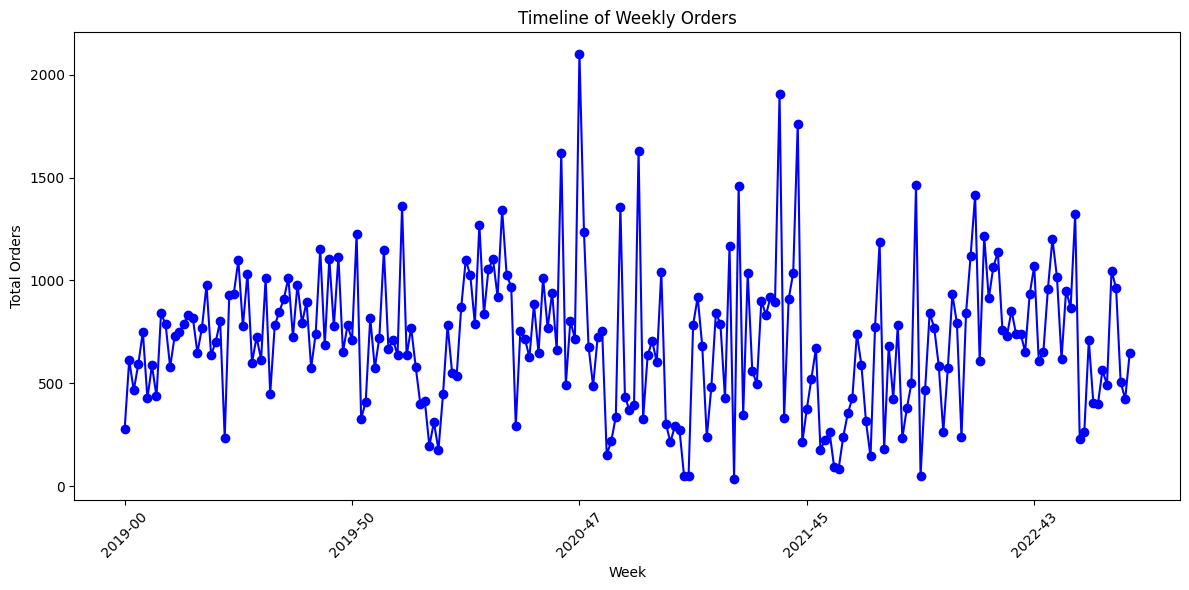

In [17]:
df['Week'] = df['Date'].dt.strftime('%Y-%U')

# Group data by 'Week' and sum 'Quantity' for each week
weekly_orders = df.groupby('Week')['Quantity'].sum()

# Plotting the timeline for weekly orders
plt.figure(figsize=(12, 6))
weekly_orders.plot(kind='line', marker='o', color='b')
plt.title('Timeline of Weekly Orders')
plt.xlabel('Week')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Train / Test split

### Transactions
###### Note: if a customer bought multiple products on same day, We will consider it one transaction

In [18]:

basket = (df 
          .groupby(['InvoiceID', 'ProductID'])['Quantity'] 
          .sum().unstack().reset_index().fillna(0) 
          .set_index('InvoiceID'))
basket


ProductID,0,1,2,3,4,5,6,7,8,9,...,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939
InvoiceID,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apriori Algorithm

In [19]:
frq_items = apriori(basket.astype(bool), min_support=0.001, use_colnames=True)
frq_items.sort_values("support",ascending=False)

,support,itemsets
34,0.058979,(192)
314,0.052251,(1756)
330,0.039296,(1830)
114,0.038795,(543)
112,0.036075,(540)
...,...,...
108,0.001002,(534)
548,0.001002,"(1456, 1460)"
549,0.001002,"(1456, 1462)"
214,0.001002,(1001)


### Association rules

In [20]:
# Generate association rules
rules = association_rules(frq_items, metric="lift", min_threshold=1)
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
424,"(164, 221)",(192),0.001861,0.058979,0.001503,0.807692,13.694501,0.001393,4.893308,0.928706
539,"(1241, 885, 1167)",(1128),0.001646,0.019827,0.001288,0.782609,39.472296,0.001256,4.508797,0.976273
538,"(1128, 885, 1167)",(1241),0.001718,0.009305,0.001288,0.750000,80.601923,0.001272,3.962780,0.989293
537,"(1128, 1241, 1167)",(885),0.001718,0.028273,0.001288,0.750000,26.527215,0.001240,3.886909,0.963959
490,"(251, 252)",(192),0.001646,0.058979,0.001217,0.739130,12.532028,0.001120,3.607246,0.921722
...,...,...,...,...,...,...,...,...,...,...
142,(192),(1436),0.058979,0.004366,0.001002,0.016990,3.891334,0.000745,1.012842,0.789588
104,(192),(270),0.058979,0.004652,0.001002,0.016990,3.651867,0.000728,1.012551,0.771681
0,(192),(70),0.058979,0.007086,0.001002,0.016990,2.397690,0.000584,1.010075,0.619468
144,(192),(1502),0.058979,0.011309,0.001002,0.016990,1.502350,0.000335,1.005779,0.355334


### FPGrowth

In [21]:
import pandas as pd
# Load your dataset into a DataFrame (assuming it's stored in a CSV file)
df = pd.read_csv('file_out2.csv')

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth


# Group products by InvoiceID
transactions = df.groupby('InvoiceID')['ProductID'].apply(list).tolist()

# Initialize TransactionEncoder
encoder = TransactionEncoder()

# Transform the transaction data into a binary encoded DataFrame
transaction_matrix = encoder.fit(transactions).transform(transactions)

# Create a new DataFrame with binary values
binary_df = pd.DataFrame(transaction_matrix, columns=encoder.columns_)

# Set the minimum support threshold
min_support = 0.001  # Adjust this based on your dataset and requirements

# Generate frequent itemsets using FP-growth
frequent_itemsets = fpgrowth(binary_df, min_support=min_support, use_colnames=True)

# Print frequent itemsets
#print(frequent_itemsets)
from mlxtend.frequent_patterns import association_rules
# Set minimum confidence threshold for the association rules
min_confidence = 0.1  # You can adjust this based on your requirements

# Generate association rules from frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
rules = rules.sort_values(['confidence', 'lift'], ascending=[False, False])
# Print the association rules
frequent_itemsets
rules


#

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
166,"(164, 221)",(192),0.001847,0.058527,0.001492,0.807692,13.800364,0.001384,4.895660,0.929254
222,"(1241, 885, 1167)",(1128),0.001634,0.019746,0.001278,0.782609,39.634345,0.001246,4.509170,0.976364
221,"(1128, 885, 1167)",(1241),0.001705,0.009305,0.001278,0.750000,80.604962,0.001263,3.962781,0.989280
220,"(1128, 1241, 1167)",(885),0.001705,0.028269,0.001278,0.750000,26.530779,0.001230,3.886924,0.963951
64,"(251, 252)",(192),0.001634,0.058527,0.001207,0.739130,12.628905,0.001112,3.608980,0.922323
...,...,...,...,...,...,...,...,...,...,...
30,(559),(192),0.010512,0.058527,0.001065,0.101351,1.731706,0.000450,1.047654,0.427024
106,(531),"(532, 527)",0.012004,0.002415,0.001207,0.100592,41.653846,0.001178,1.109157,0.987850
85,(521),(532),0.016976,0.015626,0.001705,0.100418,6.426322,0.001439,1.094257,0.858972
154,(521),(543),0.016976,0.038497,0.001705,0.100418,2.608470,0.001051,1.068834,0.627282
